In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel, DDPMScheduler

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


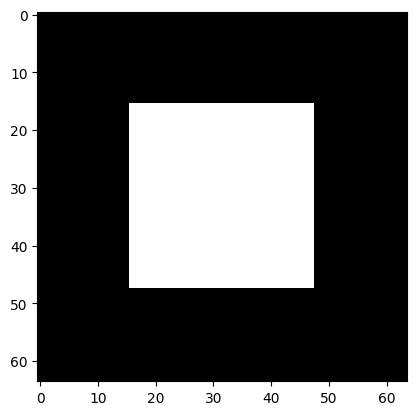

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# 1. Create a Single Image
# ------------------------------
image_size = 64  # 64x64 pixels
# Create a single-channel image: all zeros with a white square in the middle.
image = torch.zeros((1, 1, image_size, image_size), device=device)
image[:, :, 16:48, 16:48] = 1.0

plt.imshow(image[0, 0].cpu().numpy(), cmap='gray')

In [3]:
# ------------------------------
# 2. Define the Scheduler
# ------------------------------
timesteps = 200  # Total number of diffusion steps

# Here we use Diffusers' DDPMScheduler configured to use a cosine-like schedule.
# The "squaredcos_cap_v2" option is one cosine schedule available in Diffusers.
scheduler = DDPMScheduler(
    num_train_timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="squaredcos_cap_v2",  # cosine-style schedule
)

In [4]:
# ------------------------------
# 3. Instantiate the UNet Model
# ------------------------------
# Here we use Diffusers' UNet2DModel. (There are many configuration options.)
model = UNet2DModel(
    sample_size=image_size,   # image resolution
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    # For unconditional modeling, you don't need extra conditioning.
).to(device)

# Create an optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:
pred = torch.tensor([1, 2, 3], dtype=torch.float)
target = torch.tensor([2, 2, 4], dtype=torch.float)


def myLoss(pred, target):
    mse = F.mse_loss(pred, target)
    loss = mse ** (1/2)
    return loss

myLoss(pred, target)

tensor(0.8165)

Epoch 0: Loss = 0.128345


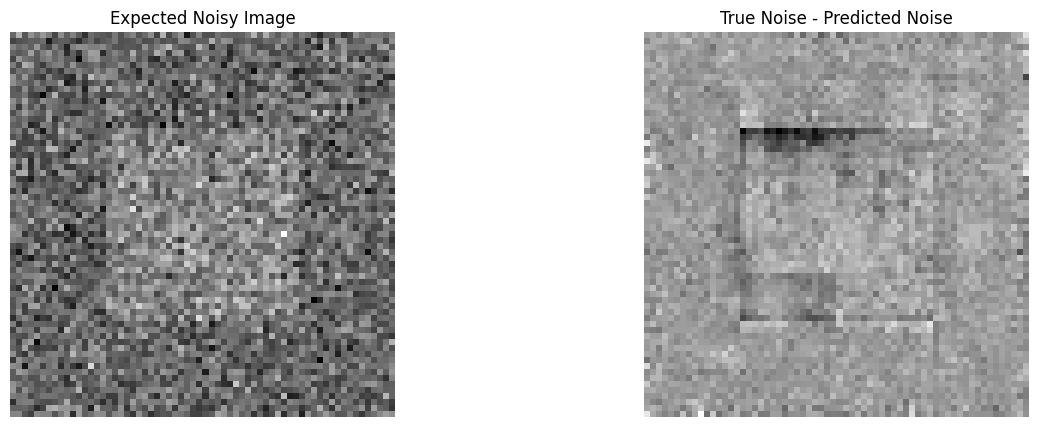

Epoch 10: Loss = 0.212107


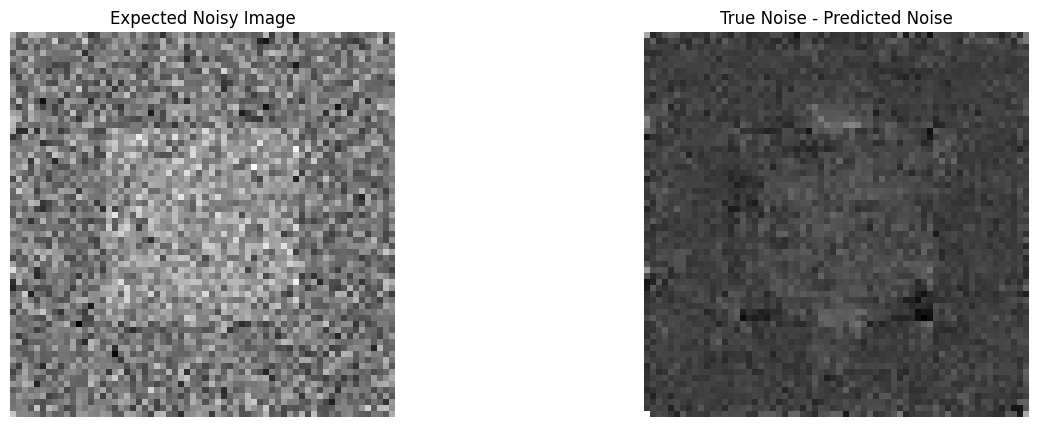

Epoch 20: Loss = 0.105811


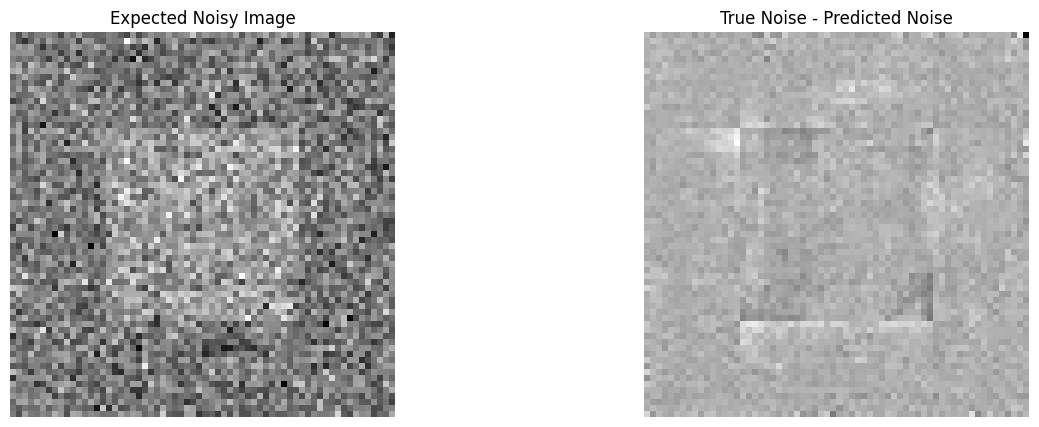

Epoch 30: Loss = 0.284158


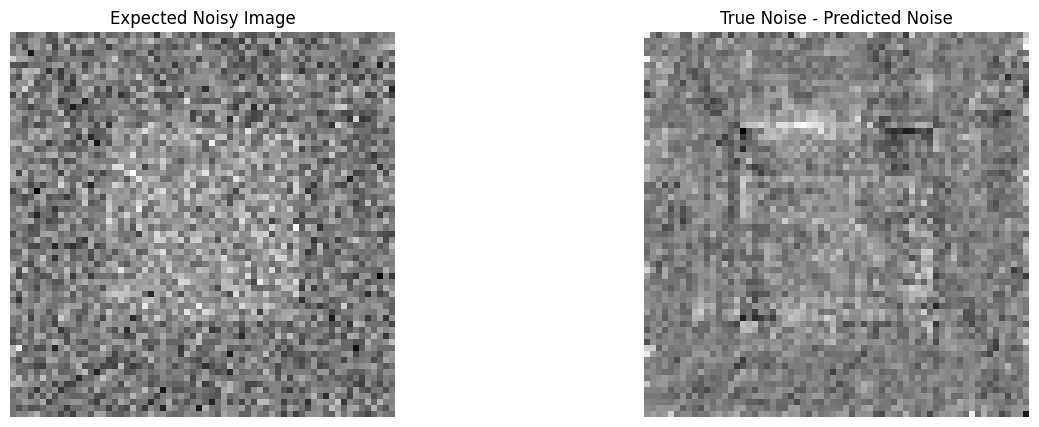

Epoch 40: Loss = 0.834521


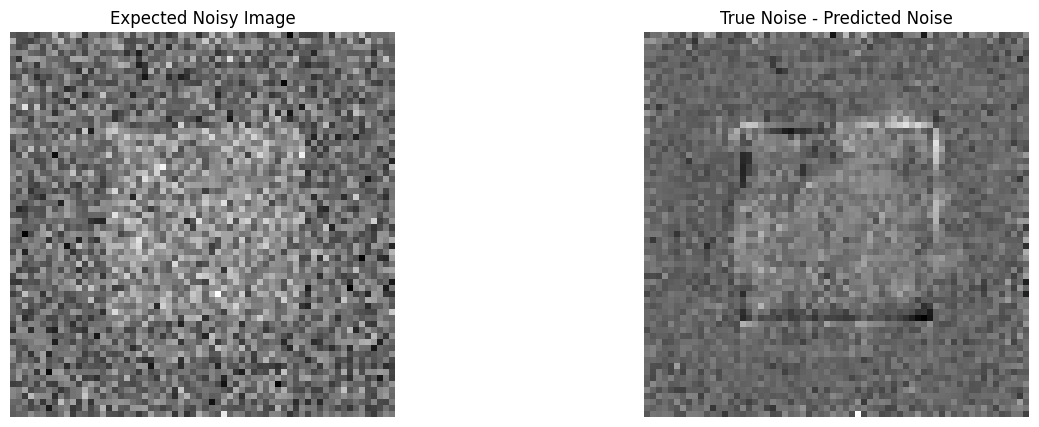

Epoch 50: Loss = 0.077696


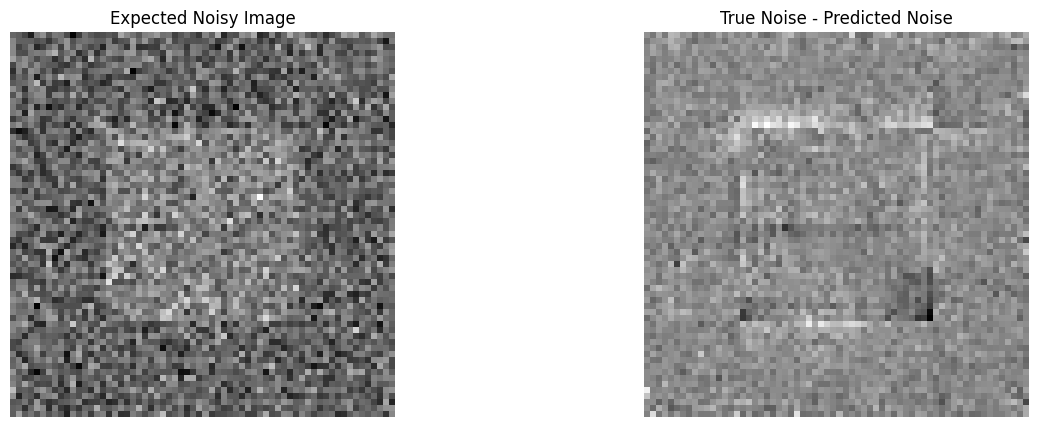

Epoch 60: Loss = 0.085021


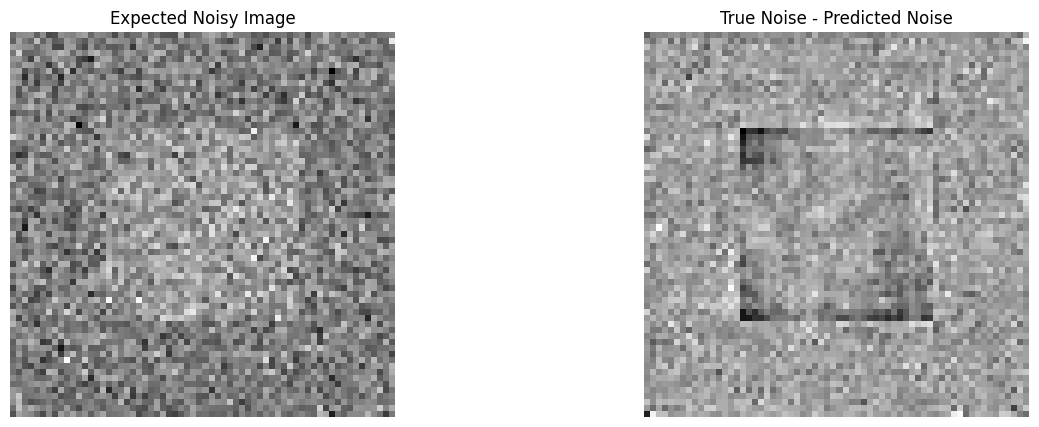

Epoch 70: Loss = 0.129529


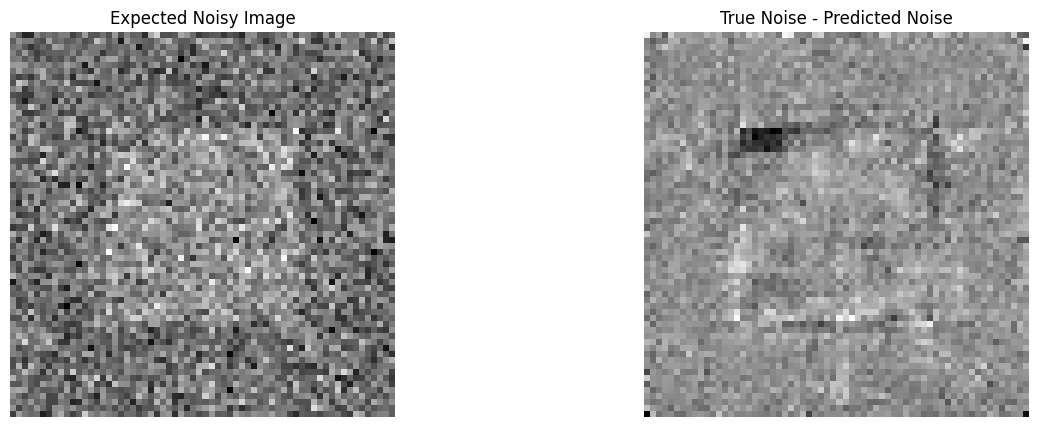

Epoch 80: Loss = 0.423596


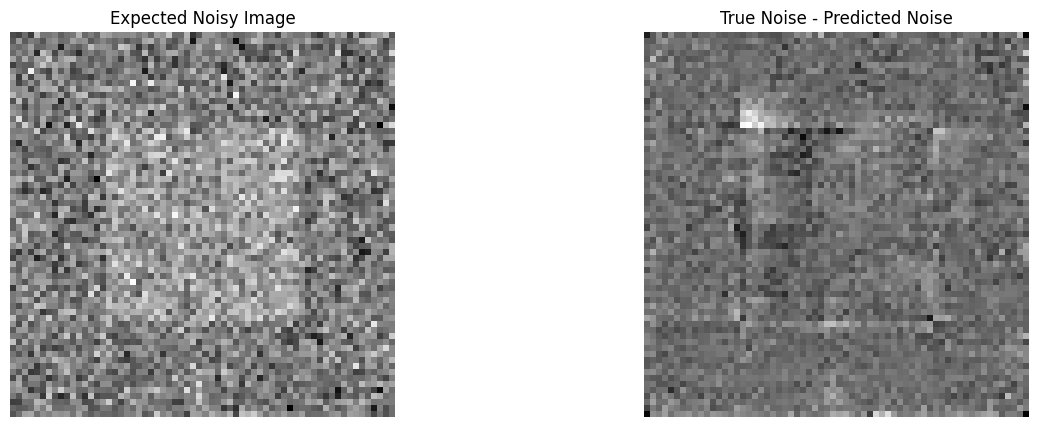

Epoch 90: Loss = 0.097405


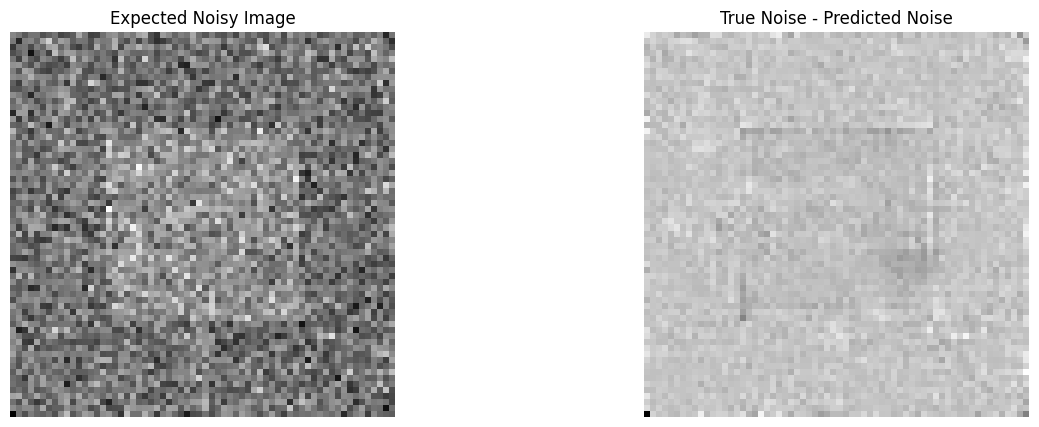

Epoch 100: Loss = 0.078639


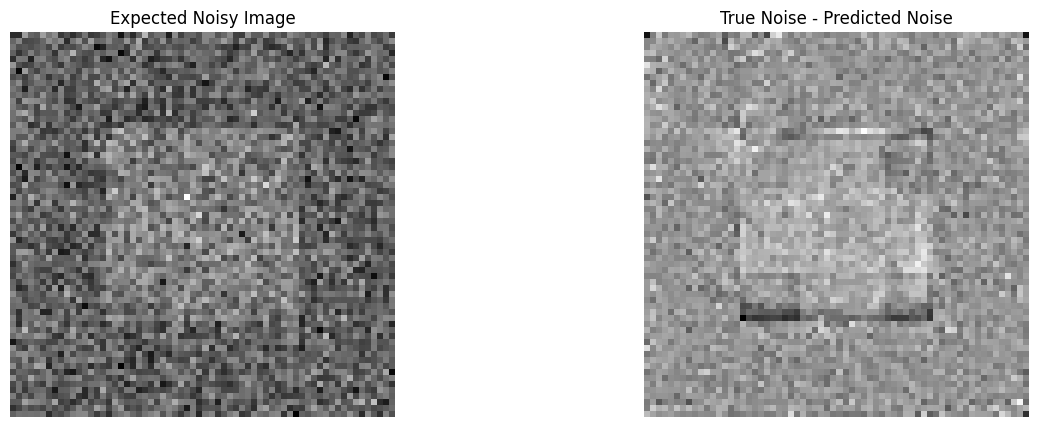

In [20]:
# ------------------------------
# 4. Training Loop
# ------------------------------
epochs = 101  # Adjust epochs as needed
model.train()  # Set the model to training mode

for epoch in range(epochs):
    optimizer.zero_grad()

    # Sample a random timestep (one per image in the batch).
    t = torch.randint(0, timesteps, (image.shape[0],), device=device).long()

    # Sample random noise.
    noise = torch.randn_like(image)

    # Use the scheduler to add noise to the image at timestep `t`.
    # This uses the forward diffusion process.
    noisy_image = scheduler.add_noise(image, noise, t)

    # Diffusers' UNet2DModel expects a timestep tensor (and will embed it internally)
    # The output is a ModelOutput object; its `.sample` attribute holds the prediction.
    model_output = model(noisy_image, t)
    pred_noise = model_output.sample

    # Compute the loss (MSE between predicted noise and the true noise).
    #loss = F.mse_loss(pred_noise, noise)
    loss = myLoss(pred_noise, noise)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
        # After a training step (or in evaluation mode)
        with torch.no_grad():
            sample_t = torch.tensor([100], device=device)
            true_noise = torch.randn_like(image)
            noisy_sample = scheduler.add_noise(image, true_noise, sample_t)
            model_output = model(noisy_sample, sample_t)
            pred_noise = model_output.sample
            # Plotting:
            fig, axs = plt.subplots(1, 2, figsize=(15, 5))

            # Plot 1: Expected Noisy Image
            axs[0].imshow(noisy_sample.cpu().squeeze().numpy(), cmap='gray')
            axs[0].set_title("Expected Noisy Image")
            axs[0].axis("off")

            # Plot 4: Difference between True Noise and Predicted Noise
            noise_diff = true_noise - pred_noise
            axs[1].imshow(noise_diff.cpu().squeeze().numpy(), cmap='gray')
            axs[1].set_title("True Noise - Predicted Noise")
            axs[1].axis("off")

            plt.show()


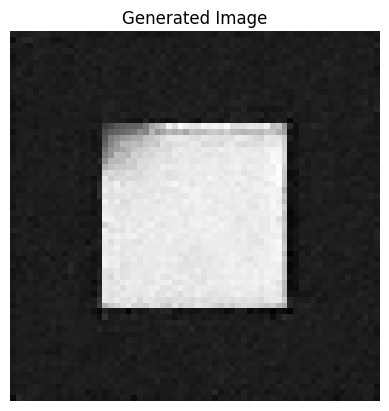

In [21]:
# ------------------------------
# 5. Sampling (Reverse Diffusion)
# ------------------------------
# Once training is done, use the scheduler's reverse process.
model.eval()
with torch.no_grad():
    # Start from pure noise.
    x = torch.randn_like(image).to(device)

    # The scheduler holds a list of timesteps; we iterate in reverse.
    for t in scheduler.timesteps:
        # Note: the scheduler.step() method expects:
        #   - model_output (the predicted noise),
        #   - the current timestep, and
        #   - the current sample.
        # It returns a StepOutput object with a `.prev_sample` attribute.
        t_tensor = torch.tensor([t], device=device).long()
        model_output = model(x, t_tensor)
        pred_noise = model_output.sample

        # Update the image sample with the scheduler's step.
        step_output = scheduler.step(pred_noise, t, x)
        x = step_output.prev_sample

    # Convert the final image to CPU and remove extra dimensions.
    sampled_image = x.cpu().squeeze().numpy()
    # Display the generated image.
plt.imshow(sampled_image, cmap='gray')
plt.title("Generated Image")
plt.axis("off")
plt.show()

In [25]:
# Display the generated image.
# plt.imshow(sampled_image, cmap='gray')
# plt.title("Generated Image")
# plt.axis("off")
# plt.show()

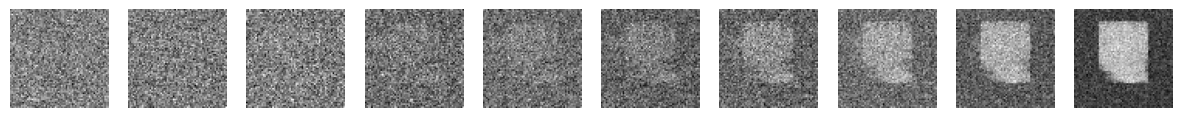

In [23]:
model.eval()
with torch.no_grad():
    x = torch.randn_like(image).to(device)
    intermediate_images = []
    for i, t in enumerate(scheduler.timesteps):
        t_tensor = torch.tensor([t], device=device).long()
        model_output = model(x, t_tensor)
        pred_noise = model_output.sample
        step_output = scheduler.step(pred_noise, t, x)
        x = step_output.prev_sample
        
        # Save some intermediate steps for visualization
        if i % 20 == 0:  # every 20 steps
            intermediate_images.append(x.cpu().squeeze().numpy())
    
    # Visualize the intermediate images
    fig, axes = plt.subplots(1, len(intermediate_images), figsize=(15, 3))
    for ax, img in zip(axes, intermediate_images):
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    plt.show()


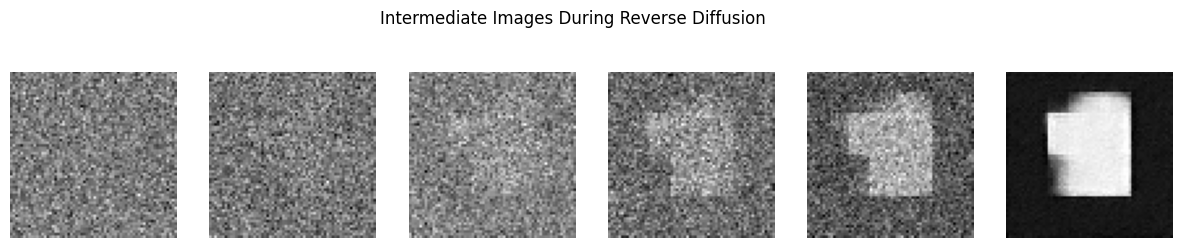

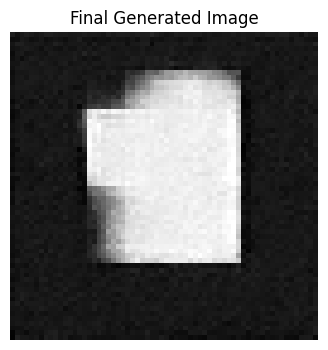

In [24]:
# Ensure the model is in evaluation mode.
model.eval()

# Optionally, set the number of inference steps (you can try fewer steps too).
num_inference_steps = timesteps  # or try a smaller number like 50 or 100
scheduler.set_timesteps(num_inference_steps)

with torch.no_grad():
    # Start from pure Gaussian noise.
    x = torch.randn_like(image).to(device)
    intermediate_images = []

    # Loop over the scheduler's timesteps (they should be ordered for reverse diffusion).
    for i, t in enumerate(scheduler.timesteps):
        # Pass the current sample x and the timestep t to the model.
        model_output = model(x, t).sample

        # Use the scheduler's step function.
        # If available, using eta=0.0 makes the process deterministic.
        step_output = scheduler.step(model_output, t, x)
        x = step_output.prev_sample

        # Save some intermediate images every few steps.
        if i % (len(scheduler.timesteps)//5) == 0 or i == len(scheduler.timesteps)-1:
            intermediate_images.append(x.detach().cpu().squeeze().numpy())

    # Final generated image:
    final_generated_image = x.detach().cpu().squeeze().numpy()

# Plot the intermediate images.
num_plots = len(intermediate_images)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 3))
for ax, img in zip(axs, intermediate_images):
    ax.imshow(img, cmap='gray')
    ax.axis("off")
plt.suptitle("Intermediate Images During Reverse Diffusion")
plt.show()

# Also display the final image.
plt.figure(figsize=(4,4))
plt.imshow(final_generated_image, cmap='gray')
plt.title("Final Generated Image")
plt.axis("off")
plt.show()
